# Импорт либ

In [2]:
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

import torch
from torch import tensor
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchsummary import summary

from PIL import Image

import numpy as np
from scipy import stats
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm 

import warnings

warnings.filterwarnings("ignore")

In [3]:
sns.set_theme()
pal = sns.set_palette([
    "#FF6347", "#4682B4", "#8A2BE2", "#FFD700", "#32CD32",
    "#FF4500", "#1E90FF", "#FF1493", "#00FA9A", "#FFDAB9",
    "#6A5ACD", "#FF8C00", "#ADFF2F", "#20B2AA", "#FF69B4",
    "#7B68EE", "#FFB6C1", "#00BFFF", "#F08080", "#DDA0DD"
])

# Гипер-параметры

In [5]:
BASE_DATA_DIR = '/kaggle/input/ml-intensive-yandex-academy-spring-2025/human_poses_data' 
TRAIN_IMG_DIR = os.path.join(BASE_DATA_DIR, 'img_train')
TEST_IMG_DIR = os.path.join(BASE_DATA_DIR, 'img_test')
TRAIN_CSV_PATH = os.path.join(BASE_DATA_DIR, 'train_answers.csv')
CATEGORIES_CSV_PATH = os.path.join(BASE_DATA_DIR, 'activity_categories.csv')
SUBMISSION_CSV_PATH = 'submission.csv'
BEST_MODEL_PATH = 'best_model.pth'

BATCH_SIZE = 48
BATCH_SIZE_2 = 32
NUM_EPOCHS = 50
NUM_EPOCHS_2 = 100
LEARNING_RATE = 0.01

# Починка меток 

In [6]:
PRESENT_CLASS_IDS = [0, 1, 2, 3, 4, 5, 6, 8, 9, 10, 11, 12, 13, 14, 16, 18]
NUM_CLASSES = len(PRESENT_CLASS_IDS) 

# Создаем словарь для маппинга оригинальных ID в новые ID (0 до NUM_CLASSES-1)
original_to_dense_map = {original_id: dense_id for dense_id, original_id in enumerate(PRESENT_CLASS_IDS)}

# Создаем обратный словарь для маппинга новых ID обратно в оригинальные (понадобится для вывода)
dense_to_original_map = {dense_id: original_id for dense_id, original_id in enumerate(PRESENT_CLASS_IDS)}

categories_df = pd.read_csv(CATEGORIES_CSV_PATH)
categories_map = categories_df.set_index('id')['category'].to_dict()

## Базовый Dataset

* **path** - исходное месторасположение всех изображений;
* **transform** - преобразования, в частности **transforms.Compose**;
* **trainFlag** - флаг **train/test** *(True/False)*;
* **file_list** - список типа *(label : int, img_path : str)*.

In [8]:
class ImageDataset(Dataset):
    def __init__(self, path, transform):
        
        self.path = path
        self.transform = transform

    def __len__(self):
        
        return len(self.file_list)

    def __getitem__(self, idx):

        file_path = os.path.join(self.path, self.file_list[idx][1])

        with Image.open(file_path) as img:
            img = self.transform(img)
            return (img, self.file_list[idx][0])

## Transforms

### Аугментация **1.0**

In [ ]:
transform1 = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomCrop(224),
    transforms.RandomHorizontalFlip(p=.54),
    transforms.RandomVerticalFlip(p=.34),
    transforms.RandomRotation([.0, 15]),
    transforms.RandomAutocontrast(.2),
    transforms.ColorJitter(
        brightness=.22,
        contrast=.22,
        saturation=[.28, .95],
        hue=[-.08, .08]
    ),
    transforms.ToTensor()
])

transformSimple = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomCrop(224),
    transforms.ToTensor()
])

### Аугментация **AntiHor**

In [ ]:
transform2 = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomCrop(224),
    transforms.RandomHorizontalFlip(p=.54),
    transforms.RandomVerticalFlip(p=.34),
    transforms.RandomRotation([.0, 10]),
    transforms.RandomAutocontrast(.2),
    transforms.ColorJitter(
        brightness=.22,
        contrast=.22,
        saturation=[.28, .95],
        hue=[-.08, .08]
    ),
    transforms.ToTensor()
])

### Аугментация **Norm1.0**

In [ ]:
transform3 = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomCrop(224),
    transforms.RandomHorizontalFlip(p=.54),
    transforms.RandomVerticalFlip(p=.34),
    transforms.RandomRotation([.0, 10]),
    transforms.RandomAutocontrast(.2),
    transforms.ColorJitter(
        brightness=.22,
        contrast=.22,
        saturation=[.28, .95],
        hue=[-.08, .08]
    ),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  
])

transformSimple2 = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  
])

### Аугментация **Norm2.0**

In [ ]:
transform4 = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomCrop(224),
    transforms.RandomHorizontalFlip(p=.54),
    transforms.RandomRotation([10, 20]),
    transforms.RandomAutocontrast(.2),
    transforms.ColorJitter(
        brightness=.22,
        contrast=.22,
        saturation=[.45, 1.5],
        hue=[-.1, .1]
    ),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  
])

### Аугментация **NormCorrected&PDF**

In [9]:
class CustomRandomRotation:
    def __init__(self, func, **kwrgs):
        
        self.function = {
            'normal' : np.random.normal,
            'chi2' : stats.chi2.rvs
        }[func]

        self.params = kwrgs

    def __call__(self, img):
        
        angle = self.function(**self.params)
        
        return transforms.functional.rotate(img, angle)

Суть в том, чтобы сделать акцент на величины с большей частотностью желаемого распределения, ниже представлен пример с **chi2** распредлением : в данном случае больший акцент на значениях промежутка **3-12**

<Axes: ylabel='Count'>

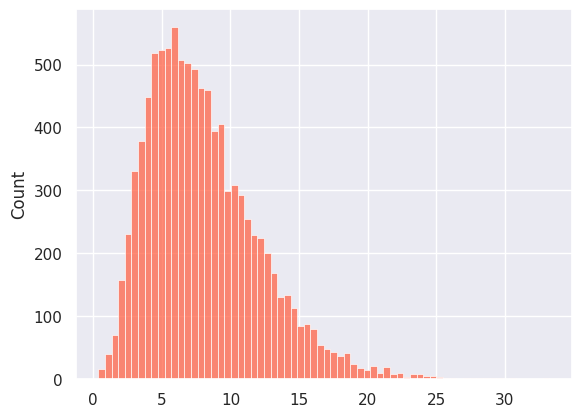

In [6]:
sns.histplot(x=stats.chi2.rvs(8, size=10000))

#### Вычисление **MEAN**, **STD**

In [ ]:
path = TRAIN_IMG_DIR

sum_pixels = torch.zeros((3,))
count = 0

sum_squares = torch.zeros((3,))

transform = transforms.Compose([transforms.ToTensor()])

for filename in os.listdir(path):
    img_path = os.path.join(path, filename)
    with Image.open(img_path) as img:
        img_tensor = transform(img)

        sum_pixels += img_tensor.mean(dim=(1, 2))
        count += 1

        sum_squares += (img_tensor ** 2).mean(dim=(1, 2))

mean = sum_pixels / count
std = (sum_squares / count - mean ** 2) ** 0.5

mean, std

In [20]:
transform5 = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomCrop(224),
    transforms.RandomHorizontalFlip(p=.5),
    CustomRandomRotation('chi2', df=8),
    transforms.RandomAutocontrast(.2),
    transforms.ColorJitter(
        brightness=0,
        contrast=.2,
        saturation=[.45, 1.5],
        hue=[-.05, .05]
    ),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=tensor([0.4674, 0.4497, 0.4122]), 
        std=tensor([0.2739, 0.2694, 0.2740])) # (tensor([0.4674, 0.4497, 0.4122]), tensor([0.2739, 0.2694, 0.2740]))
]) 

transformSimple3 = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=tensor([0.4674, 0.4497, 0.4122]), 
        std=tensor([0.2739, 0.2694, 0.2740])) 
])

## Train-test-split

Идея в том, чтобы тосавать и разбивать **список путей к изображениям**, а после по ним уже получать соотв. данные

In [10]:
def train_test(path, path_answers, test_size=0.2, train_trans=None, test_trans=None, batch_size=64):

    file_list = os.listdir(path)
    answers_df = pd.read_csv(path_answers)

    target_dict = answers_df.set_index('img_id')['target_feature'].to_dict()

    objs = []
    for file in file_list:
        img_id = int(os.path.splitext(file)[0])
        target = target_dict.get(img_id)
        if target is not None and target in original_to_dense_map:
            dense_target = original_to_dense_map[target] 
            objs.append((dense_target, file)) 
            
    train_files, test_files = train_test_split(
    objs, test_size=test_size, random_state=42)

    train_dataset = ImageDataset(path, train_trans)
    train_dataset.file_list = train_files
    
    test_dataset = ImageDataset(path, test_trans)
    test_dataset.file_list = test_files
    
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
    test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

    return train_dataloader, test_dataloader

In [11]:
def plot_images(data_loader):
    first_batch = next(iter(data_loader))

    images = first_batch[0]
    labels = first_batch[1]

    fig, axes = plt.subplots(nrows=2, ncols=6, figsize=(15, 5))

    classesByInLabels = pd.read_csv(CATEGORIES_CSV_PATH)

    for y in range(2):
        for x in range(6):
            axes[y, x].imshow(images[12 // (y + 1) - (x + 1)].permute(1, 2, 0))
            axes[y, x].set(xticks=[])
            axes[y, x].set(yticks=[])
            axes[y, x].set_title(classesByInLabels[classesByInLabels['id'] == int(labels[12 // (y + 1) - (x + 1)])]['category'].iloc[0])
            
    plt.plot()

In [ ]:
train_dataloader, test_dataloader = train_test(
    TRAIN_IMG_DIR, 
    TRAIN_CSV_PATH,
    train_trans=transform1,
    test_trans=transformSimple,
    batch_size=BATCH_SIZE)

In [ ]:
plot_images(train_dataloader) # тут слетели метки классов(

In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # Выбираем GPU для баффа к скорости
device

device(type='cuda')

# Модели

In [14]:
class BasicBlock(nn.Module):
    expansion = 1
    def __init__(self, in_channels, out_channels, stride=1):
        super(BasicBlock, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.skip_connetcion = nn.Sequential()
        
        if stride != 1 or in_channels != self.expansion * out_channels:
            self.skip_connetcion = nn.Sequential(
                nn.Conv2d(in_channels, self.expansion * out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion * out_channels)
            )
            
    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.skip_connetcion(x)
        out = F.relu(out)
        return out

class ResNet(nn.Module):
    def __init__(self, block, num_blocks):
        super(ResNet, self).__init__()
        
        self.in_channels = 64
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, NUM_CLASSES)

    def _make_layer(self, block, out_channels, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for s in strides:
            layers.append(block(self.in_channels, out_channels, s))
            self.in_channels = out_channels * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.maxpool(out)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.avgpool(out)
        out = torch.flatten(out, 1)
        out = self.fc(out)
        return out

model = ResNet(BasicBlock, [2, 2, 2, 2]).to(device)

## ResNet18

In [15]:
loss_function = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=0.9, weight_decay=0.0001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

## Суммари модели

In [ ]:
summary(model, input_size=(3, 224, 224), device=device.type)

## Функции Тренеровки/Валидации

In [16]:
def train_epoch(model, dataloader, optimizer, loss_fn, device):
    model.train()
    running_loss = 0.0
    total_samples = 0
    processed_batches = 0

    all_preds = []  
    all_labels = [] 

    progress_bar = tqdm(dataloader, desc="Training", leave=False)
    for batch in progress_bar:
        inputs, labels = batch  
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs.data, 1)
        total_samples += labels.size(0)
        processed_batches += 1

        all_preds.append(predicted.cpu())
        all_labels.append(labels.cpu())

        progress_bar.set_postfix(loss=f"{loss.item():.4f}")


    epoch_loss = running_loss / total_samples

    all_preds = torch.cat(all_preds)
    all_labels = torch.cat(all_labels)

    f1 = f1_score(all_labels.numpy(), all_preds.numpy(), average='weighted', zero_division=0)

    return epoch_loss, f1 

def evaluate(model, dataloader, loss_fn, device):
    model.eval()
    running_loss = 0.0
    all_labels = []
    all_predictions = []
    total_samples = 0

    progress_bar = tqdm(dataloader, desc="Evaluating", leave=False)
    with torch.no_grad():
        for batch in progress_bar:
            if batch is None or batch[0] is None or batch[1] is None:
                continue
            inputs, labels = batch 
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = loss_fn(outputs, labels)

            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs.data, 1)

            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())
            total_samples += labels.size(0)


    epoch_loss = running_loss / total_samples
    f1 = f1_score(all_labels, all_predictions, average='macro', labels=list(range(NUM_CLASSES)), zero_division=0)


    return epoch_loss, f1

## Тренеровка 

In [17]:
def train_model(model, device, train_dataloader, test_dataloader, optimizer, loss_function, scheduler, epochs) :
    print("Начало тренировки")
    history = {'train_loss': [], 'train_f1': [], 'val_loss': [], 'val_f1': []} 
    best_val_f1 = 0.0
    
    if train_dataloader is None or test_dataloader is None:
        print("Ошибка: DataLoader'ы не инициализированы.")
    else:
        for epoch in range(epochs):
            
            train_loss, train_f1 = train_epoch(model, train_dataloader, optimizer, loss_function, device)
    
            
            val_loss, val_f1 = evaluate(model, test_dataloader, loss_function, device)
    
    
            history['train_loss'].append(train_loss)
            history['train_f1'].append(train_f1)
            history['val_loss'].append(val_loss)
            history['val_f1'].append(val_f1)
    
    
            print(f"Эпоха {epoch+1}/{epochs}:")
            print(f"  Train Loss: {train_loss:.4f} | Train F1 (Macro): {train_f1:.4f}")
            print(f"  Val Loss:   {val_loss:.4f} | Val F1 (Macro): {val_f1:.4f}")
            print(f"  LR: {optimizer.param_groups[0]['lr']:.6f}") 
    
    
            if scheduler:
                if isinstance(scheduler, torch.optim.lr_scheduler.ReduceLROnPlateau):
                     scheduler.step(val_f1)
                else:
                     scheduler.step() 
    
    
            if val_f1 > best_val_f1:
                print(f"  F1 улучшился ({best_val_f1:.4f} --> {val_f1:.4f}). Сохраняю модель в {BEST_MODEL_PATH}...")
                best_val_f1 = val_f1
                torch.save(model.state_dict(), BEST_MODEL_PATH)
    
    
        print("Тренеровка завершена!")
        print(f"Лучшая F1 (Macro) на валидации: {best_val_f1:.4f}")
    
    
        if os.path.exists(BEST_MODEL_PATH) and best_val_f1 > 0:
            print(f"Загружаю лучшую модель из {BEST_MODEL_PATH}")
            model.load_state_dict(torch.load(BEST_MODEL_PATH))
        else:
            print("Лучшая модель не сохранена(")

In [ ]:
train_model(model, device, train_dataloader, test_dataloader, optimizer, loss_function, scheduler, NUM_EPOCHS)

## Отображение результатов

In [ ]:
plt.figure(figsize=(18, 5))

plt.subplot(1, 3, 1)
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.subplot(1, 3, 2)
plt.plot(history['train_f1'], label='Train F1 (Macro)')
plt.title('F1')
plt.xlabel('Epoch')
plt.ylabel('F1')
plt.legend()
plt.grid(True)

plt.subplot(1, 3, 3)
plt.plot(history['val_f1'], label='Validation F1 (Macro)')
plt.title('F1')
plt.xlabel('Epoch')
plt.ylabel('F1')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

## BottleNeck - новый блок?

Да, именно **BottleNeck** послужит ключевым инструментом нашей иной модели, причиной выдвинуть решение создания архитектурой с использованием **BottleNeck** стал следующий ряд преимуществ:
* **Количество параметров** - их меньше, поскольку изначально берется **Conv** с **kernel_size=1** вместо **kernel_size=3**, а также **kernel_size** применяется изначально с меньшим кол-во каналов, после уже передается в следующий, где происходит увеличение в зависимости от **expansion**-фактора;
* **Вычислительная сложность** - по сравнению с **BasicBlock** в среднем снижается в **10** раз;
* **Качество модели** - по статистике имеет **Score** не хуже/лучше при пред. преимуществах. 

In [18]:
class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_channels, out_channels, stride=1):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        
        self.conv3 = nn.Conv2d(out_channels, out_channels * self.expansion, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(out_channels * self.expansion)
        
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels * self.expansion:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels * self.expansion, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels * self.expansion)
            )

    def forward(self, x):
        out = torch.relu(self.bn1(self.conv1(x)))
        out = torch.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        return torch.relu(out)


### CrocodiloNet - что это?

**CrocodiloNet** представляет из себя нейронку класса **ResNet**, однако его принципиальная разница от пред. моделей заключается в том, что вместо **BasicBlock** используется **BottleNeck**, что обеспечивает *экономию вычислительных процессов, временных ресурсов* путем *минимизации параметров* и позволяет нам создавать более *глубокие сети*

In [21]:
train_dataloader, test_dataloader = train_test(
    TRAIN_IMG_DIR, 
    TRAIN_CSV_PATH,
    train_trans=transform5,
    test_trans=transformSimple3,
    batch_size=48)

In [23]:
crocodiloModel = ResNet(Bottleneck, [2, 3, 4, 3]).to(device)

In [18]:
summary(crocodiloModel, input_size=(3, 224, 224), device=device.type)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
            Conv2d-7           [-1, 64, 56, 56]          36,864
       BatchNorm2d-8           [-1, 64, 56, 56]             128
            Conv2d-9          [-1, 256, 56, 56]          16,384
      BatchNorm2d-10          [-1, 256, 56, 56]             512
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
       Bottleneck-13          [-1, 256, 56, 56]               0
           Conv2d-14           [-1, 64,

In [24]:
optimizer2 = torch.optim.AdamW(crocodiloModel.parameters(), lr=0.01)
scheduler2 = torch.optim.lr_scheduler.StepLR(optimizer2, step_size=7, gamma=0.5)

In [ ]:
train_model(crocodiloModel, device, train_dataloader, test_dataloader, optimizer2, loss_function, scheduler2, NUM_EPOCHS_2)

**Явное затухание**, что мы можем наблюдать вот уже близ **10-15-х** эпох. Предположительно, связано это с подобранным **LR=0.01** - **завышен**, также стоит опробовать **scheduler** c другими параметрами

In [26]:
crocodiloModel = ResNet(Bottleneck, [2, 3, 4, 3]).to(device)

In [27]:
optimizer3 = torch.optim.AdamW(
    crocodiloModel.parameters(), 
    lr=0.001,
    weight_decay=0.05
)

scheduler3 = torch.optim.lr_scheduler.SequentialLR(
    optimizer3,
    schedulers=[
        torch.optim.lr_scheduler.LinearLR(optimizer3, start_factor=0.33, total_iters=3),
        torch.optim.lr_scheduler.StepLR(optimizer3, step_size=7, gamma=0.5)
    ],
    milestones=[3]
)

In [ ]:
train_model(crocodiloModel, device, train_dataloader, test_dataloader, optimizer3, loss_function, scheduler3, 100)

### Дообучение

In [23]:
crocodiloModel.load_state_dict(torch.load('/kaggle/input/crocodilolast90/pytorch/default/1/last_model.pth', map_location=device))

<All keys matched successfully>

In [ ]:
train_model(crocodiloModel, device, train_dataloader, test_dataloader, optimizer3, loss_function, scheduler3, 60)

Начало тренировки


Training:   0%|          | 0/207 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/52 [00:00<?, ?it/s]

Эпоха 1/60:
  Train Loss: 0.2551 | Train F1 (Macro): 0.9134
  Val Loss:   1.6441 | Val F1 (Macro): 0.5871
  LR: 0.001000
  F1 улучшился (0.0000 --> 0.5871). Сохраняю модель в best_model.pth...


Training:   0%|          | 0/207 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/52 [00:00<?, ?it/s]

Эпоха 2/60:
  Train Loss: 0.2269 | Train F1 (Macro): 0.9250
  Val Loss:   1.7161 | Val F1 (Macro): 0.5876
  LR: 0.001000
  F1 улучшился (0.5871 --> 0.5876). Сохраняю модель в best_model.pth...


Training:   0%|          | 0/207 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/52 [00:00<?, ?it/s]

Эпоха 3/60:
  Train Loss: 0.2425 | Train F1 (Macro): 0.9180
  Val Loss:   1.8674 | Val F1 (Macro): 0.5689
  LR: 0.001000


Training:   0%|          | 0/207 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/52 [00:00<?, ?it/s]

Эпоха 4/60:
  Train Loss: 0.2298 | Train F1 (Macro): 0.9213
  Val Loss:   1.9845 | Val F1 (Macro): 0.5622
  LR: 0.001000


Training:   0%|          | 0/207 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/52 [00:00<?, ?it/s]

Эпоха 5/60:
  Train Loss: 0.2037 | Train F1 (Macro): 0.9317
  Val Loss:   1.7423 | Val F1 (Macro): 0.5773
  LR: 0.001000


Training:   0%|          | 0/207 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/52 [00:00<?, ?it/s]

Эпоха 6/60:
  Train Loss: 0.2017 | Train F1 (Macro): 0.9326
  Val Loss:   1.6815 | Val F1 (Macro): 0.5908
  LR: 0.001000
  F1 улучшился (0.5876 --> 0.5908). Сохраняю модель в best_model.pth...


Training:   0%|          | 0/207 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/52 [00:00<?, ?it/s]

Эпоха 7/60:
  Train Loss: 0.2086 | Train F1 (Macro): 0.9286
  Val Loss:   1.8248 | Val F1 (Macro): 0.5708
  LR: 0.001000


Training:   0%|          | 0/207 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/52 [00:00<?, ?it/s]

Эпоха 8/60:
  Train Loss: 0.2512 | Train F1 (Macro): 0.9156
  Val Loss:   1.6437 | Val F1 (Macro): 0.5795
  LR: 0.001000


Training:   0%|          | 0/207 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/52 [00:00<?, ?it/s]

Эпоха 9/60:
  Train Loss: 0.2304 | Train F1 (Macro): 0.9261
  Val Loss:   1.6989 | Val F1 (Macro): 0.5907
  LR: 0.001000


Training:   0%|          | 0/207 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/52 [00:00<?, ?it/s]

Эпоха 10/60:
  Train Loss: 0.2328 | Train F1 (Macro): 0.9221
  Val Loss:   1.7547 | Val F1 (Macro): 0.5745
  LR: 0.001000


Training:   0%|          | 0/207 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/52 [00:00<?, ?it/s]

Эпоха 11/60:
  Train Loss: 0.1997 | Train F1 (Macro): 0.9362
  Val Loss:   1.6530 | Val F1 (Macro): 0.6028
  LR: 0.001000
  F1 улучшился (0.5908 --> 0.6028). Сохраняю модель в best_model.pth...


Training:   0%|          | 0/207 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/52 [00:00<?, ?it/s]

Эпоха 12/60:
  Train Loss: 0.1851 | Train F1 (Macro): 0.9402
  Val Loss:   1.7214 | Val F1 (Macro): 0.5731
  LR: 0.001000


Training:   0%|          | 0/207 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/52 [00:00<?, ?it/s]

Эпоха 13/60:
  Train Loss: 0.1848 | Train F1 (Macro): 0.9384
  Val Loss:   1.9291 | Val F1 (Macro): 0.5816
  LR: 0.001000


Training:   0%|          | 0/207 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/52 [00:00<?, ?it/s]

Эпоха 14/60:
  Train Loss: 0.2258 | Train F1 (Macro): 0.9266
  Val Loss:   1.8911 | Val F1 (Macro): 0.5645
  LR: 0.001000


Training:   0%|          | 0/207 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/52 [00:00<?, ?it/s]

Эпоха 15/60:
  Train Loss: 0.2030 | Train F1 (Macro): 0.9356
  Val Loss:   1.6023 | Val F1 (Macro): 0.6150
  LR: 0.001000
  F1 улучшился (0.6028 --> 0.6150). Сохраняю модель в best_model.pth...


Training:   0%|          | 0/207 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/52 [00:00<?, ?it/s]

Эпоха 16/60:
  Train Loss: 0.1538 | Train F1 (Macro): 0.9485
  Val Loss:   1.7794 | Val F1 (Macro): 0.5604
  LR: 0.001000


Training:   0%|          | 0/207 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/52 [00:00<?, ?it/s]

Эпоха 17/60:
  Train Loss: 0.1964 | Train F1 (Macro): 0.9350
  Val Loss:   1.7964 | Val F1 (Macro): 0.5871
  LR: 0.001000


Training:   0%|          | 0/207 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/52 [00:00<?, ?it/s]

Эпоха 18/60:
  Train Loss: 0.1940 | Train F1 (Macro): 0.9348
  Val Loss:   1.8863 | Val F1 (Macro): 0.5775
  LR: 0.001000


Training:   0%|          | 0/207 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/52 [00:00<?, ?it/s]

Эпоха 19/60:
  Train Loss: 0.2209 | Train F1 (Macro): 0.9264
  Val Loss:   1.7494 | Val F1 (Macro): 0.5952
  LR: 0.001000


Training:   0%|          | 0/207 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/52 [00:00<?, ?it/s]

Эпоха 20/60:
  Train Loss: 0.2206 | Train F1 (Macro): 0.9262
  Val Loss:   1.7442 | Val F1 (Macro): 0.5962
  LR: 0.001000


Training:   0%|          | 0/207 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/52 [00:00<?, ?it/s]

Эпоха 21/60:
  Train Loss: 0.1769 | Train F1 (Macro): 0.9405
  Val Loss:   1.6777 | Val F1 (Macro): 0.6026
  LR: 0.001000


Training:   0%|          | 0/207 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/52 [00:00<?, ?it/s]

Эпоха 22/60:
  Train Loss: 0.2055 | Train F1 (Macro): 0.9338
  Val Loss:   1.9120 | Val F1 (Macro): 0.5814
  LR: 0.001000


Training:   0%|          | 0/207 [00:00<?, ?it/s]

### Больше дообучения!

In [30]:
crocodiloModel.load_state_dict(torch.load('/kaggle/input/bestcrocodilo115/pytorch/default/1/bestmodel115.pth', map_location=device))

<All keys matched successfully>

In [31]:
train_model(crocodiloModel, device, train_dataloader, test_dataloader, optimizer3, loss_function, scheduler3, 15)

Начало тренировки


Training:   0%|          | 0/207 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/52 [00:00<?, ?it/s]

Эпоха 1/15:
  Train Loss: 0.0723 | Train F1 (Macro): 0.9792
  Val Loss:   1.5481 | Val F1 (Macro): 0.6362
  LR: 0.000330
  F1 улучшился (0.0000 --> 0.6362). Сохраняю модель в best_model.pth...


Training:   0%|          | 0/207 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/52 [00:00<?, ?it/s]

Эпоха 2/15:
  Train Loss: 0.1067 | Train F1 (Macro): 0.9673
  Val Loss:   1.6268 | Val F1 (Macro): 0.6330
  LR: 0.000553


Training:   0%|          | 0/207 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/52 [00:00<?, ?it/s]

Эпоха 3/15:
  Train Loss: 0.1455 | Train F1 (Macro): 0.9500
  Val Loss:   1.8856 | Val F1 (Macro): 0.5842
  LR: 0.000777


Training:   0%|          | 0/207 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/52 [00:00<?, ?it/s]

Эпоха 4/15:
  Train Loss: 0.2685 | Train F1 (Macro): 0.9089
  Val Loss:   1.7920 | Val F1 (Macro): 0.5879
  LR: 0.001000


Training:   0%|          | 0/207 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/52 [00:00<?, ?it/s]

Эпоха 5/15:
  Train Loss: 0.2524 | Train F1 (Macro): 0.9157
  Val Loss:   1.7128 | Val F1 (Macro): 0.5905
  LR: 0.001000


Training:   0%|          | 0/207 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/52 [00:00<?, ?it/s]

Эпоха 6/15:
  Train Loss: 0.2222 | Train F1 (Macro): 0.9277
  Val Loss:   1.8449 | Val F1 (Macro): 0.5800
  LR: 0.001000


Training:   0%|          | 0/207 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/52 [00:00<?, ?it/s]

Эпоха 7/15:
  Train Loss: 0.1371 | Train F1 (Macro): 0.9579
  Val Loss:   1.6663 | Val F1 (Macro): 0.6019
  LR: 0.001000


Training:   0%|          | 0/207 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/52 [00:00<?, ?it/s]

Эпоха 8/15:
  Train Loss: 0.1833 | Train F1 (Macro): 0.9401
  Val Loss:   1.8180 | Val F1 (Macro): 0.5904
  LR: 0.001000


Training:   0%|          | 0/207 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/52 [00:00<?, ?it/s]

Эпоха 9/15:
  Train Loss: 0.1987 | Train F1 (Macro): 0.9351
  Val Loss:   1.8875 | Val F1 (Macro): 0.5800
  LR: 0.001000


Training:   0%|          | 0/207 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/52 [00:00<?, ?it/s]

Эпоха 10/15:
  Train Loss: 0.2394 | Train F1 (Macro): 0.9227
  Val Loss:   1.8549 | Val F1 (Macro): 0.5613
  LR: 0.001000


Training:   0%|          | 0/207 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/52 [00:00<?, ?it/s]

Эпоха 11/15:
  Train Loss: 0.0702 | Train F1 (Macro): 0.9788
  Val Loss:   1.5109 | Val F1 (Macro): 0.6421
  LR: 0.000500
  F1 улучшился (0.6362 --> 0.6421). Сохраняю модель в best_model.pth...


Training:   0%|          | 0/207 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/52 [00:00<?, ?it/s]

Эпоха 12/15:
  Train Loss: 0.0464 | Train F1 (Macro): 0.9869
  Val Loss:   1.6324 | Val F1 (Macro): 0.6288
  LR: 0.000500


Training:   0%|          | 0/207 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/52 [00:00<?, ?it/s]

Эпоха 13/15:
  Train Loss: 0.0729 | Train F1 (Macro): 0.9773
  Val Loss:   1.5609 | Val F1 (Macro): 0.6384
  LR: 0.000500


Training:   0%|          | 0/207 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/52 [00:00<?, ?it/s]

Эпоха 14/15:
  Train Loss: 0.0599 | Train F1 (Macro): 0.9816
  Val Loss:   1.5319 | Val F1 (Macro): 0.6398
  LR: 0.000500


Training:   0%|          | 0/207 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/52 [00:00<?, ?it/s]

Эпоха 15/15:
  Train Loss: 0.0614 | Train F1 (Macro): 0.9824
  Val Loss:   1.6135 | Val F1 (Macro): 0.6387
  LR: 0.000500
Тренеровка завершена!
Лучшая F1 (Macro) на валидации: 0.6421
Загружаю лучшую модель из best_model.pth


In [32]:
train_model(crocodiloModel, device, train_dataloader, test_dataloader, optimizer3, loss_function, scheduler3, 10)

Начало тренировки


Training:   0%|          | 0/207 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/52 [00:00<?, ?it/s]

Эпоха 1/10:
  Train Loss: 0.0607 | Train F1 (Macro): 0.9811
  Val Loss:   1.5466 | Val F1 (Macro): 0.6514
  LR: 0.000500
  F1 улучшился (0.0000 --> 0.6514). Сохраняю модель в best_model.pth...


Training:   0%|          | 0/207 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/52 [00:00<?, ?it/s]

Эпоха 2/10:
  Train Loss: 0.0460 | Train F1 (Macro): 0.9859
  Val Loss:   1.6841 | Val F1 (Macro): 0.6259
  LR: 0.000500


Training:   0%|          | 0/207 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/52 [00:00<?, ?it/s]

Эпоха 3/10:
  Train Loss: 0.0471 | Train F1 (Macro): 0.9862
  Val Loss:   1.5973 | Val F1 (Macro): 0.6534
  LR: 0.000250
  F1 улучшился (0.6514 --> 0.6534). Сохраняю модель в best_model.pth...


Training:   0%|          | 0/207 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/52 [00:00<?, ?it/s]

Эпоха 4/10:
  Train Loss: 0.0368 | Train F1 (Macro): 0.9902
  Val Loss:   1.5400 | Val F1 (Macro): 0.6581
  LR: 0.000250
  F1 улучшился (0.6534 --> 0.6581). Сохраняю модель в best_model.pth...


Training:   0%|          | 0/207 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/52 [00:00<?, ?it/s]

Эпоха 5/10:
  Train Loss: 0.0268 | Train F1 (Macro): 0.9928
  Val Loss:   1.5622 | Val F1 (Macro): 0.6508
  LR: 0.000250


Training:   0%|          | 0/207 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/52 [00:00<?, ?it/s]

Эпоха 6/10:
  Train Loss: 0.0201 | Train F1 (Macro): 0.9948
  Val Loss:   1.5892 | Val F1 (Macro): 0.6599
  LR: 0.000250
  F1 улучшился (0.6581 --> 0.6599). Сохраняю модель в best_model.pth...


Training:   0%|          | 0/207 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/52 [00:00<?, ?it/s]

Эпоха 7/10:
  Train Loss: 0.0235 | Train F1 (Macro): 0.9930
  Val Loss:   1.5915 | Val F1 (Macro): 0.6528
  LR: 0.000250


Training:   0%|          | 0/207 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/52 [00:00<?, ?it/s]

Эпоха 8/10:
  Train Loss: 0.0339 | Train F1 (Macro): 0.9903
  Val Loss:   1.6849 | Val F1 (Macro): 0.6439
  LR: 0.000250


Training:   0%|          | 0/207 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/52 [00:00<?, ?it/s]

Эпоха 9/10:
  Train Loss: 0.0332 | Train F1 (Macro): 0.9912
  Val Loss:   1.6579 | Val F1 (Macro): 0.6402
  LR: 0.000250


Training:   0%|          | 0/207 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/52 [00:00<?, ?it/s]

Эпоха 10/10:
  Train Loss: 0.0253 | Train F1 (Macro): 0.9931
  Val Loss:   1.6126 | Val F1 (Macro): 0.6500
  LR: 0.000125
Тренеровка завершена!
Лучшая F1 (Macro) на валидации: 0.6599
Загружаю лучшую модель из best_model.pth


In [1]:
torch.save(crocodiloModel.state_dict(), "last_model.pth")

NameError: name 'torch' is not defined

### ResNet2

Версия **ResNet** с добавленным **Dropout** в полносвязный слой для предотвращения *переобучения*

In [ ]:
class ResNet2(ResNet):
    def __init__(self, *args, **kwargs) :
        super(self).__init__(*args, **kwargs)
    def forward(self, x):
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.maxpool(out)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.avgpool(out)
        out = torch.flatten(out, 1)
        out = nn.Dropout(0.2)(out)
        out = self.fc(out)
        return out

## Отправка предсказаний 

In [33]:
class SubmissionImageDataset(Dataset):
    def __init__(self, img_dir, transform=None):
        self.img_dir = img_dir
        self.transform = transform
        all_files = [f for f in os.listdir(img_dir) if os.path.isfile(os.path.join(img_dir, f))]
        self.file_list = sorted(all_files, key=lambda f: int(os.path.splitext(f)[0]))
        print(f"Тестовые файлы отсортированы численно (найдено {len(self.file_list)}).")


    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        img_name = self.file_list[idx]
        img_path = os.path.join(self.img_dir, img_name)
        image_id = os.path.splitext(img_name)[0]

        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, image_id


submission_dataset = SubmissionImageDataset(img_dir=TEST_IMG_DIR, transform=transformSimple3)

submission_loader = DataLoader(
    submission_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=4,
    pin_memory=True
)



print(f"Загрузка весов модели из {BEST_MODEL_PATH}...")
crocodiloModel.load_state_dict(torch.load(BEST_MODEL_PATH, map_location=device))
print("Веса модели успешно загружены.")


crocodiloModel.eval()
crocodiloModel.to(device)

all_pred_original_labels = []
all_image_ids = []

print("Начало предсказания на тестовых данных...")
with torch.no_grad():
    for image_batch, ids_batch in tqdm(submission_loader, desc="Predicting"):
        if image_batch is None: continue

        image_batch = image_batch.to(device)
        y_pred_logits = crocodiloModel(image_batch)
        y_pred_dense_label = torch.argmax(y_pred_logits, dim=1)
        dense_preds_list = y_pred_dense_label.cpu().tolist()


        original_preds_batch = []
        for dense_pred in dense_preds_list:
             original_pred = dense_to_original_map.get(dense_pred)
             if original_pred is None:
                 original_preds_batch.append(-1)
             else:
                 original_preds_batch.append(original_pred)

        all_pred_original_labels.extend(original_preds_batch)
        all_image_ids.extend(list(ids_batch))

print("Предсказание завершено.")

print(f"Создание DataFrame с {len(all_image_ids)} записями...")
df_preds = pd.DataFrame({
    'id': all_image_ids,
    'target_feature': all_pred_original_labels
})

df_preds['id_int_temp'] = df_preds['id'].astype(int)
df_preds = df_preds.sort_values(by='id_int_temp').drop(columns=['id_int_temp'])
df_preds = df_preds.reset_index(drop=True) 
df_preds.to_csv(SUBMISSION_CSV_PATH, index=False)
print(f"Файл предсказаний успешно сохранен в {SUBMISSION_CSV_PATH}")
print("\nПервые 5 строк файла предсказаний:")
print(df_preds.head())
print("\nУникальные предсказанные метки:")
print(sorted(df_preds['target_feature'].unique()))

Тестовые файлы отсортированы численно (найдено 5301).
Загрузка весов модели из best_model.pth...
Веса модели успешно загружены.
Начало предсказания на тестовых данных...


Predicting:   0%|          | 0/111 [00:00<?, ?it/s]

Предсказание завершено.
Создание DataFrame с 5301 записями...
Файл предсказаний успешно сохранен в submission.csv

Первые 5 строк файла предсказаний:
   id  target_feature
0   0               0
1   3               0
2   5               2
3   8              18
4  14               0

Уникальные предсказанные метки:
[0, 1, 2, 3, 4, 5, 6, 8, 9, 10, 11, 12, 13, 14, 16, 18]


In [ ]:
!ls